# 필요한 라이브러리 import

In [275]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
from sklearn.metrics import mean_absolute_error,mean_squared_error
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer,PowerTransformer
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from itertools import combinations
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import L2
from scipy.stats import spearmanr
import tensorflow as tf
import statsmodels.stats.api as sms
import statsmodels.regression.linear_model as smf
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn import datasets
from sklearn.metrics import silhouette_score
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore')
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)
%matplotlib inline

# 데이터로드

In [276]:
# 빈 데이터 프레임 생성

fm_data_df = pd.DataFrame(columns=['이름','포지션','리그','골/90','도움/90','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

# 모든 데이터 프레임 이어붙이기
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

# 데이터 프레임 컬럼명 변경 및 자료형 변경
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)
fm_data_df = fm_data_df.astype({'파울 획득':np.int64,'태클 성공률':np.int64})

# 공격수만 추출
forward_df = fm_data_df[fm_data_df['포지션']=='공격수']
forward_df = forward_df.reset_index(drop=True)

In [277]:
forward_df['골/90']

0      0.404040
1      0.332410
2      0.820046
3      0.751252
4      0.348224
         ...   
766    0.708661
767    0.166667
768    0.607956
769    0.213144
770    0.124138
Name: 골/90, Length: 771, dtype: float64

# 데이터 EDA

## 모델 생성에 사용할 독립변수, 종속변수 선별

In [278]:
num_col = [forward_df.columns[i] for i,x in enumerate(forward_df.dtypes) if x == 'int64' or x == 'float64']
independent_value = set(num_col) - set(['평균획득승점/경기','출장시간','승','무','패','경기당 팀 득점/90','경기당 팀 실점/90'])
dependent_value = '평균획득승점/경기'

## 결측치 확인

In [279]:
forward_df.isna().sum()

이름              0
포지션             0
리그              0
골/90            0
도움/90           0
경기당 팀 득점/90     0
경기당 팀 실점/90     0
크로스 성공률         0
파울 획득           0
반칙 수/90         0
기회 창출/90        0
경기당 유효 슈팅/90    0
경기당 슈팅/90       0
인터셉트/90         0
달린 거리/90분       0
공중볼시도/90        0
태클 성공률          0
경기당 패스 시도/90    0
경기당 패스 성공/90    0
키패스/90          0
태클 성공/90        0
드리블 성공/90       0
헤더 성공/90        0
크로스 시도/90       0
평균획득승점/경기       0
승               0
무               0
패               0
시즌              0
구단              0
dtype: int64

## 변수 별 분포 확인

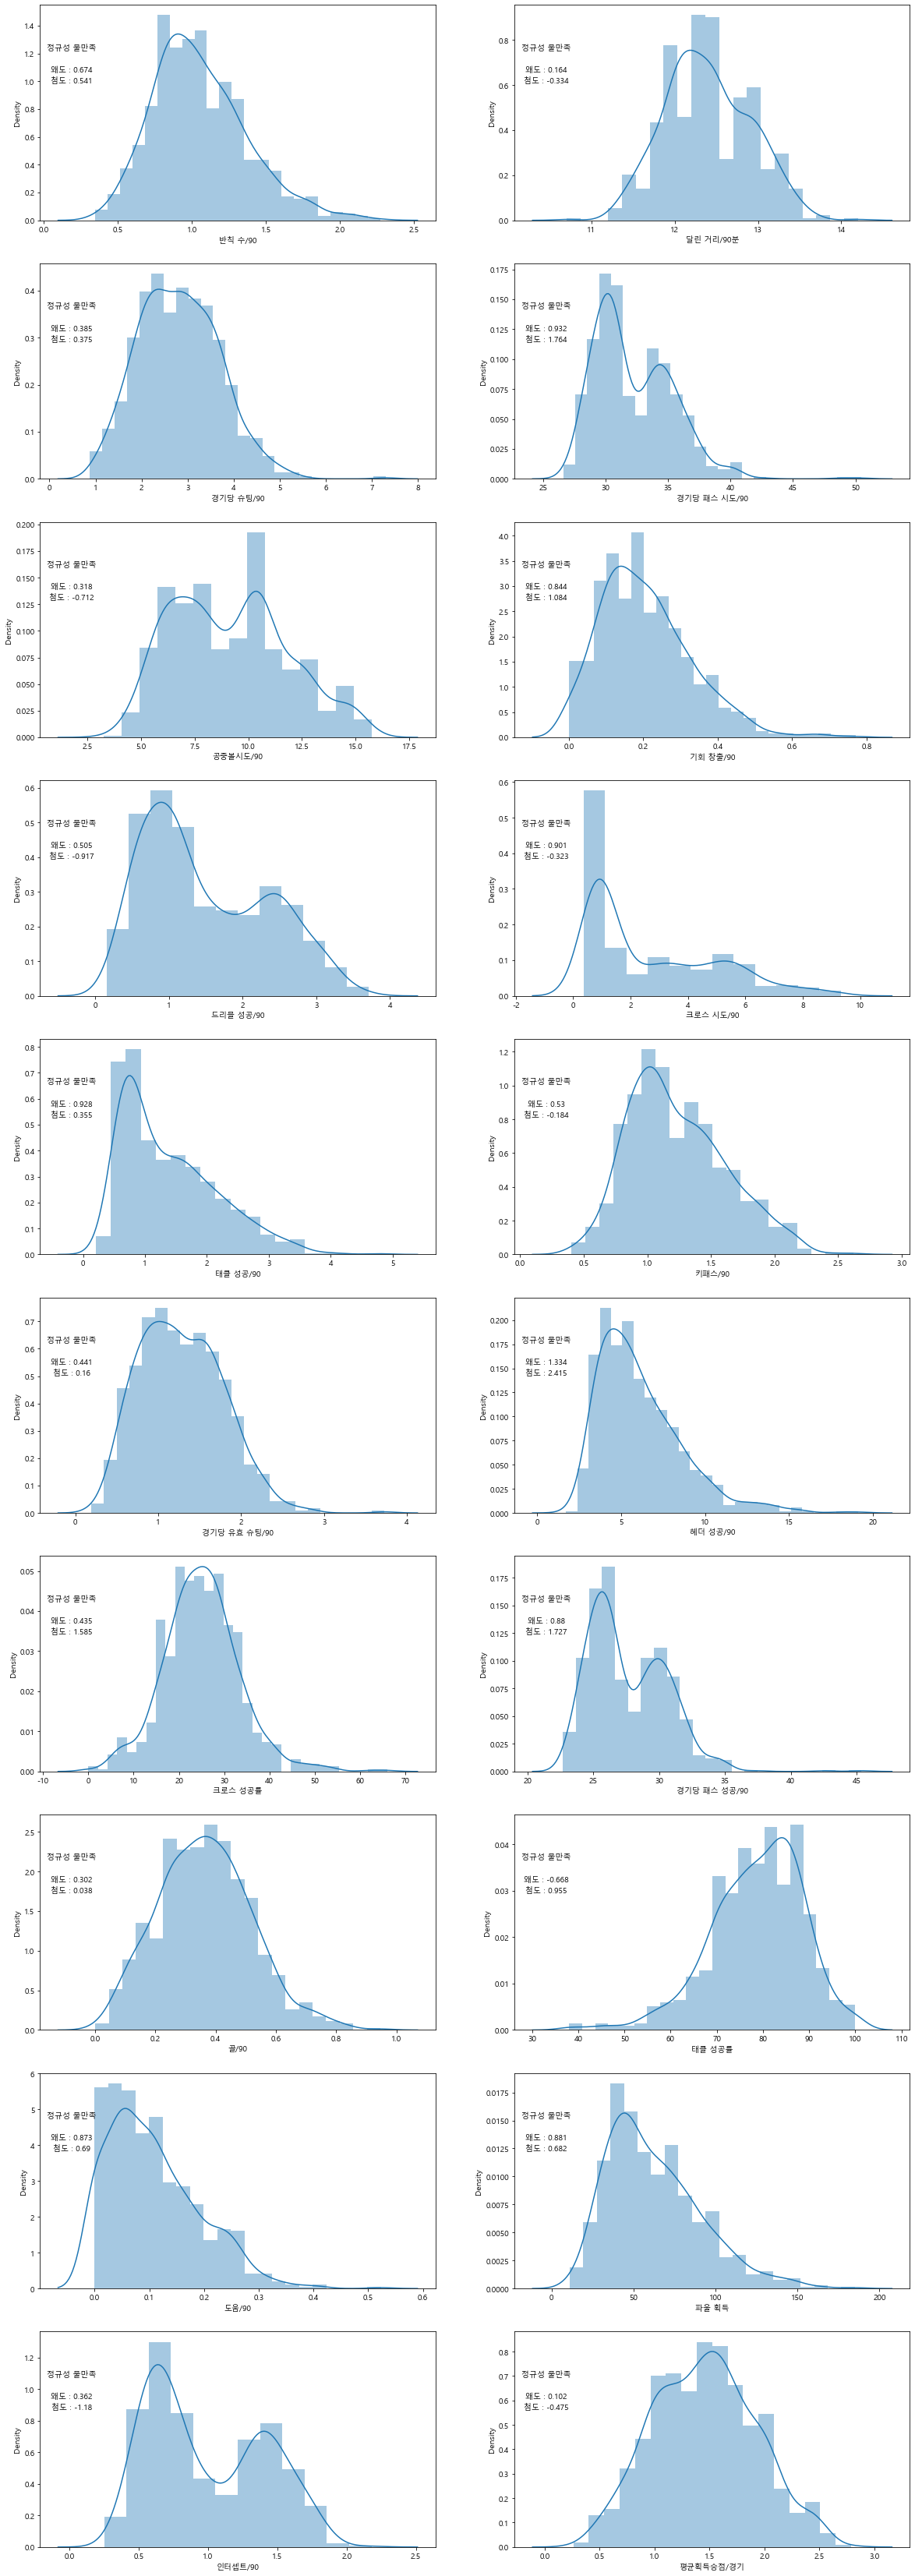

In [280]:
figs , axes = plt.subplots(10,2,figsize=(20,60))

for i,(ax,feature) in enumerate(zip(axes.ravel()[:-1],independent_value)):
    data = forward_df.loc[:,feature]
    sns.distplot(data,ax=ax)
    if stats.shapiro(data)[1]>= 0.05: 
        ax.text(x=0.08,y=0.8,s='정규성 만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(x=0.08,y=0.8,s='정규성 불만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    skew = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    ax.text(x=0.08,y=0.7,s=f'왜도 : {np.round(skew,3)}',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(x=0.08,y=0.65,s=f'첨도 : {np.round(kurtosis,3)}',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    

last_ax = axes.ravel()[-1]
depen_data = forward_df.loc[:,dependent_value]
sns.distplot(depen_data,ax=last_ax)

if stats.shapiro(depen_data)[1]>= 0.05: 
    last_ax.text(x=0.08,y=0.8,s='정규성 만족',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
else:
    last_ax.text(x=0.08,y=0.8,s='정규성 불만족',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
    
skew = stats.skew(depen_data)
kurtosis = stats.kurtosis(depen_data)
last_ax.text(x=0.08,y=0.7,s=f'왜도 : {np.round(skew,3)}',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
last_ax.text(x=0.08,y=0.65,s=f'첨도 : {np.round(kurtosis,3)}',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)

plt.show()
plt.close()

## 선형성 검정

모든 변수 선형성 만족

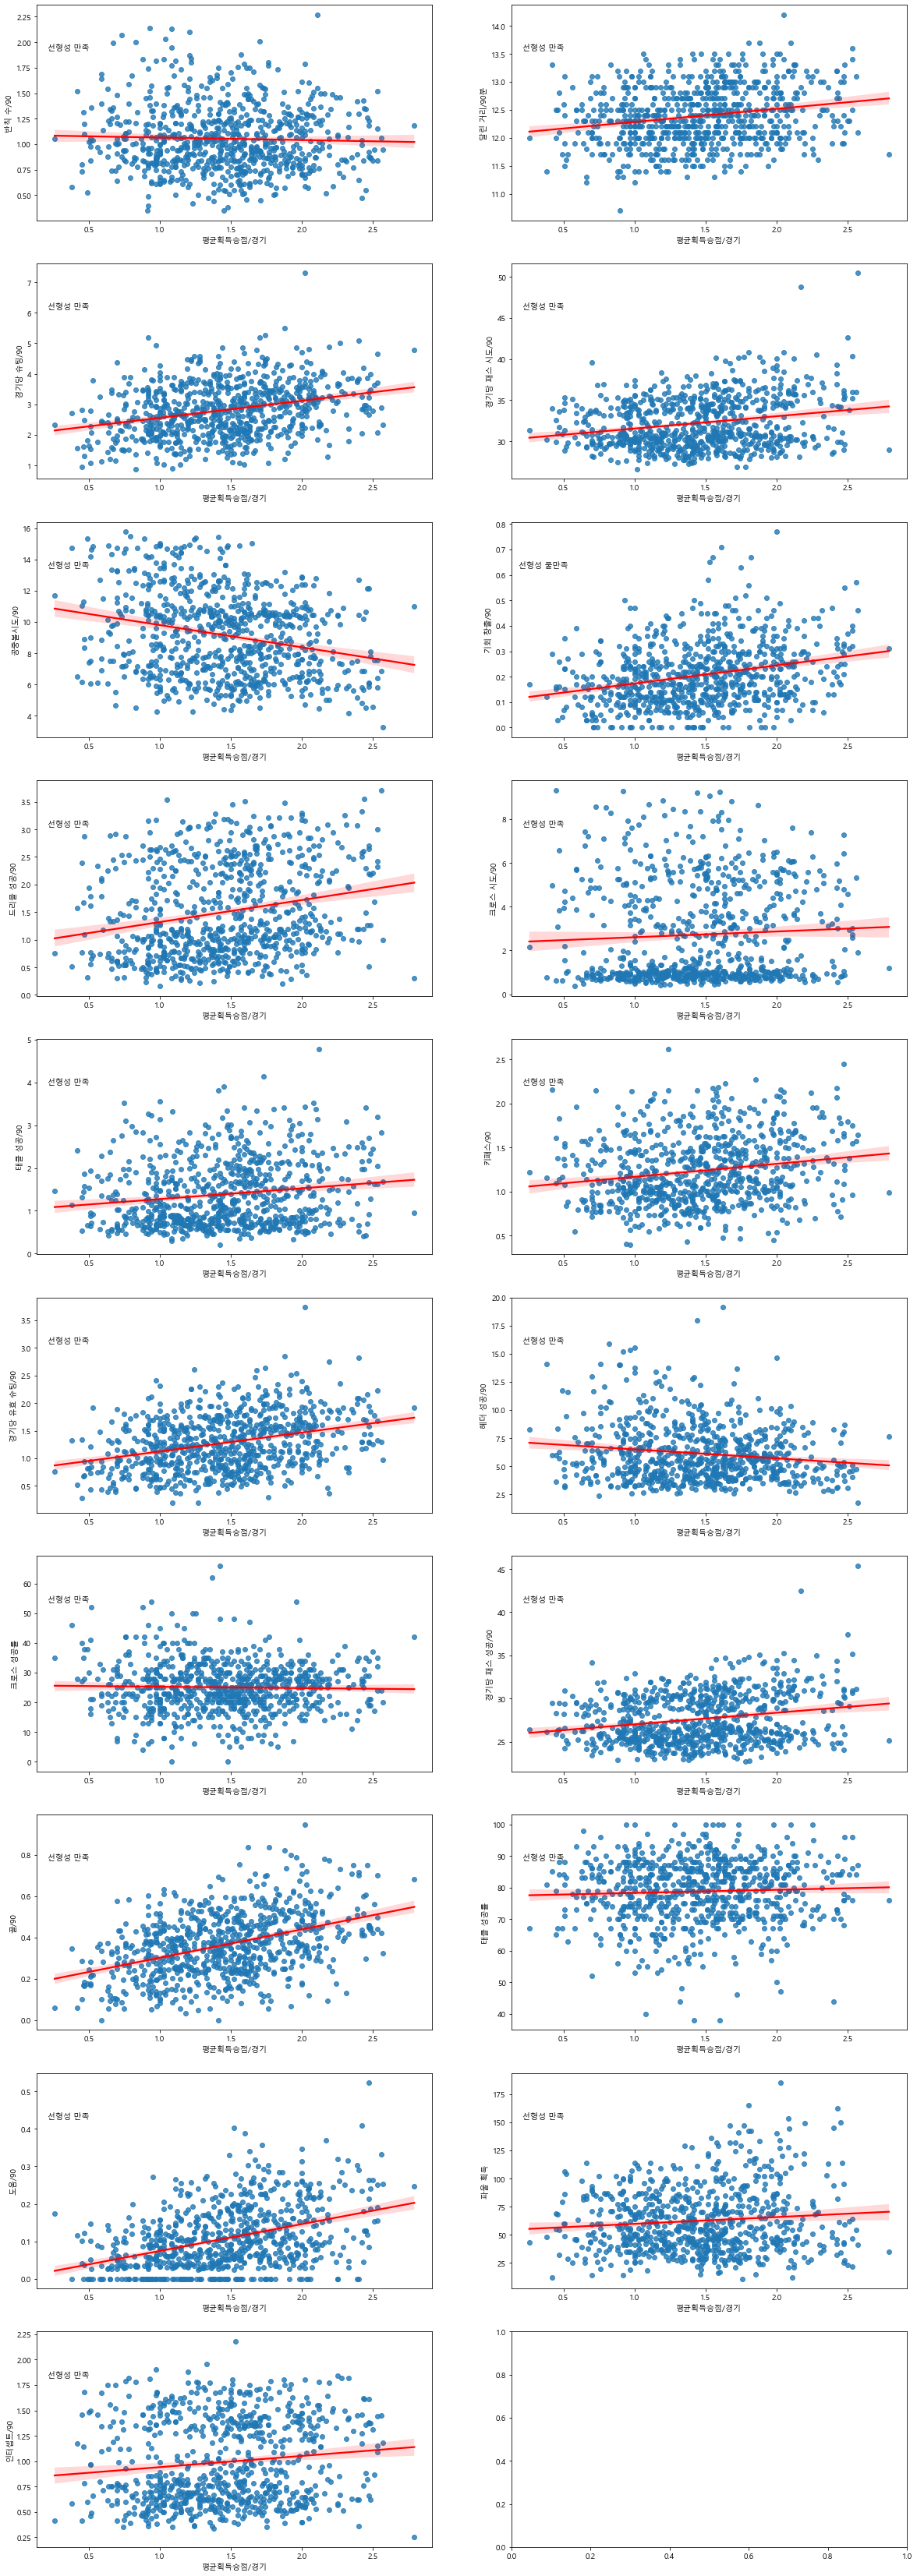

In [281]:
figs , axes = plt.subplots(10,2,figsize=(20,60))


# 독립변수 시각화
for i,(ax,feature) in enumerate(zip(axes.ravel()[:-1],independent_value)):
    sns.regplot(x=dependent_value,y=feature,data=forward_df,line_kws={'color': 'red'},ax=ax)
    model = smf.OLS(forward_df[dependent_value],forward_df[feature]).fit()
    lin_p = sms.linear_rainbow(model,frac=0.5)[1]
    if lin_p>= 0.1: 
        ax.text(x=0.08,y=0.8,s='선형성 만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(x=0.08,y=0.8,s='선형성 불만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

## 이상치 탐지

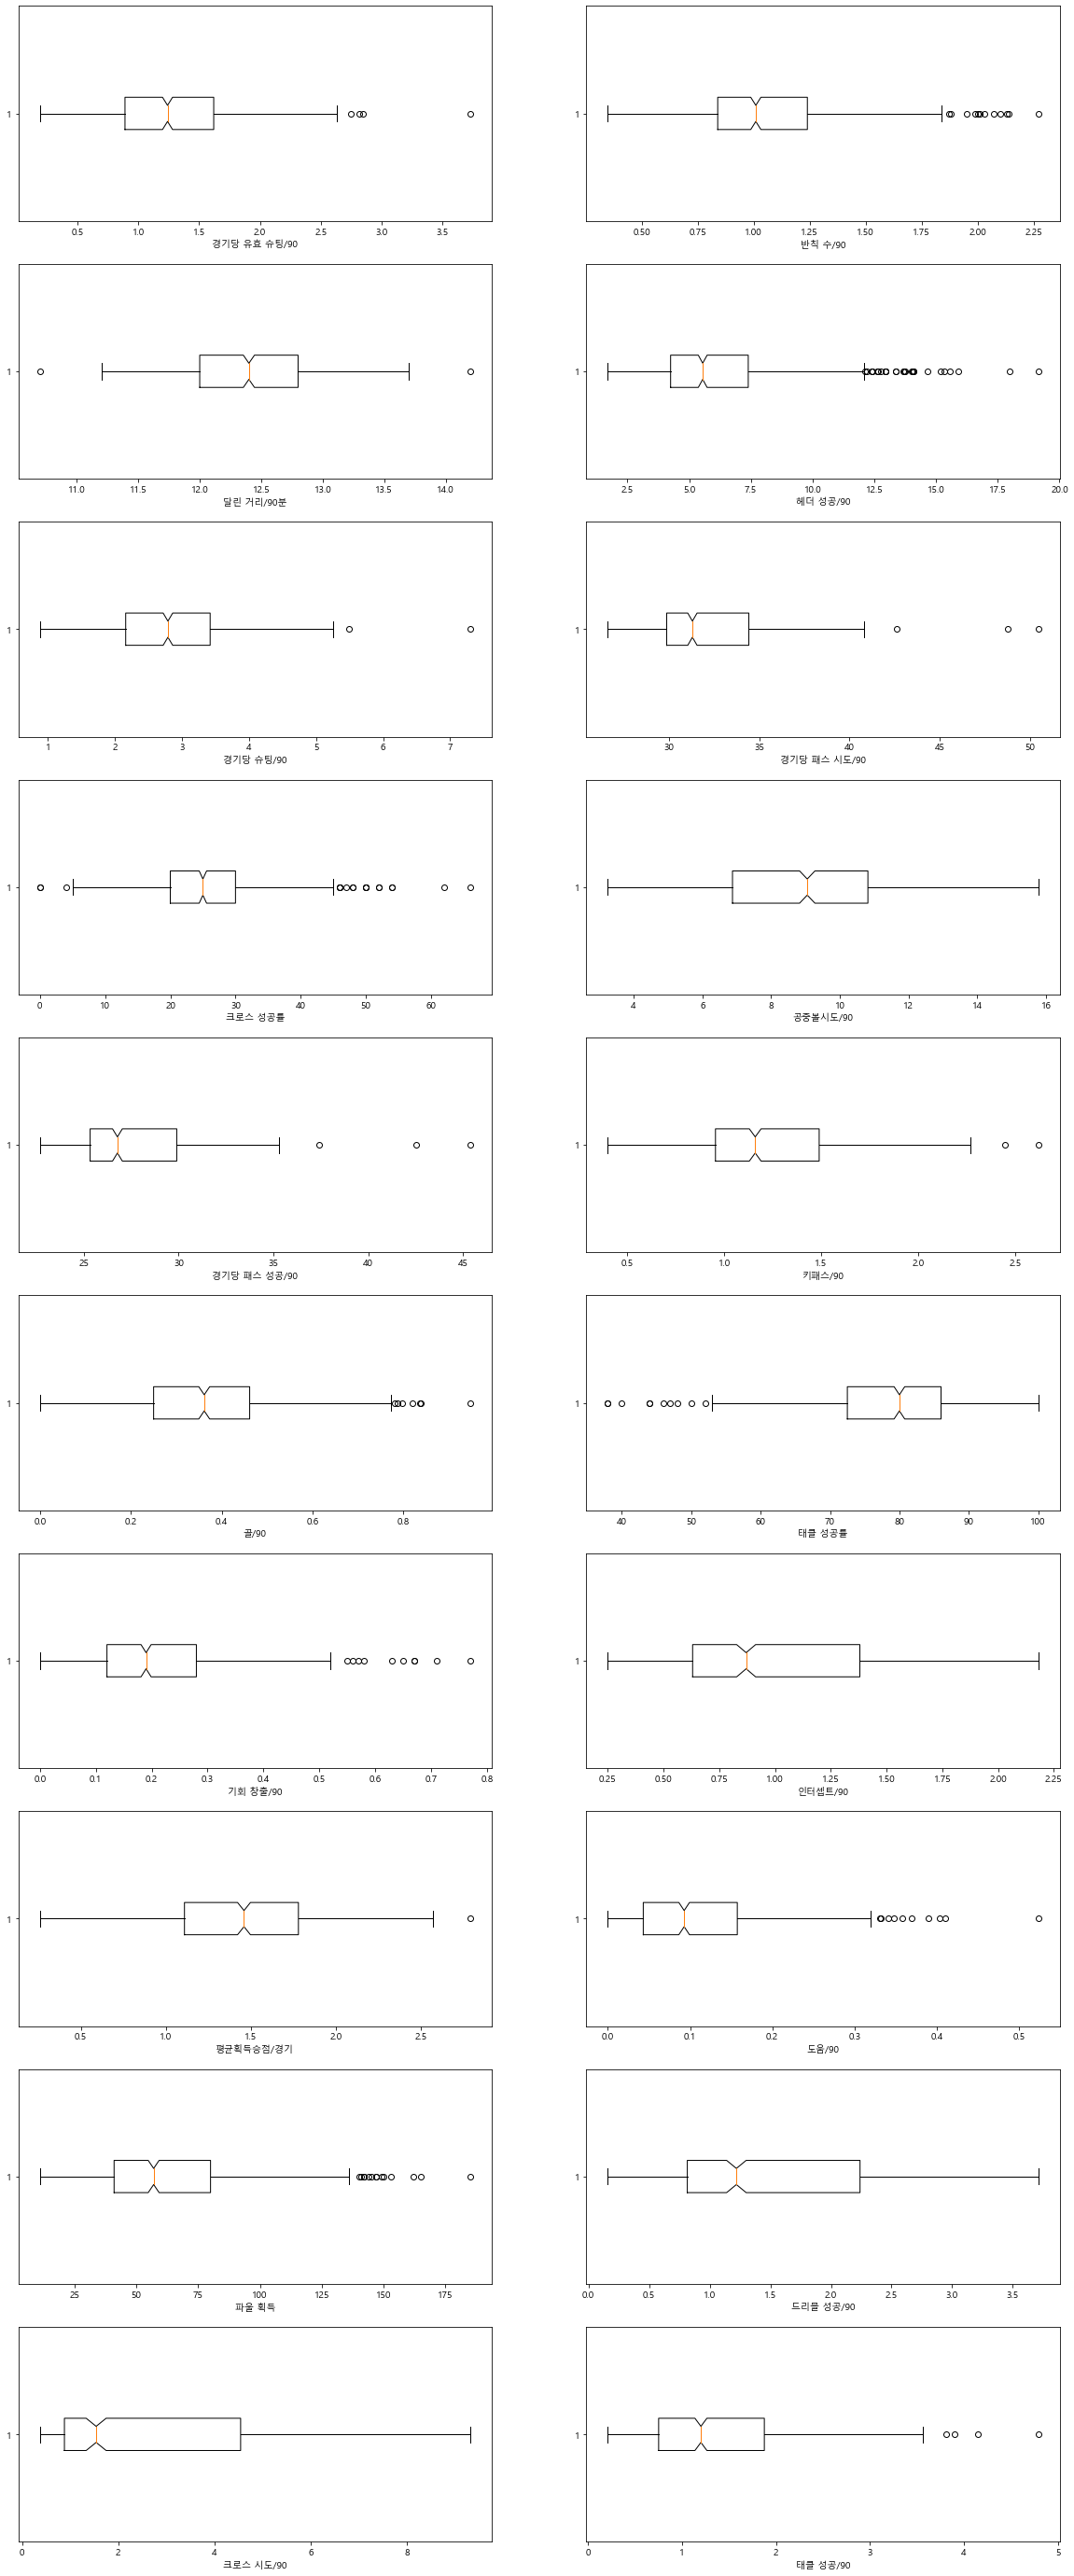

In [282]:
# 모든 변수의 Box plot 시각화

fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),independent_value | set([dependent_value]))) :
    ax.set_xlabel(feature)
    ax.boxplot(forward_df.loc[:,feature],notch=1,vert=0)
    
plt.show()

In [283]:
# 제거해야될 인덱스 셋
total = set([])

for feature in independent_value:
    
    data = forward_df[feature].to_numpy()   
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.7)
    low_bound = Q1 - 1.5 * (Q3-Q1)
    high_bound = Q3 + 1.5 * (Q3-Q1)
    count = 0
    
    for i,v in enumerate(data):
        if v < low_bound or v > high_bound:
            count += 1
            total.add(i)
            
    print(f'{feature}중 이상치는 {count}개 비율은 약 {np.round(count/990*100,3)}% 입니다',end='\n\n')
    
print(f'이상치가 있는 row의 갯수는 총 990개의 데이터 중 {len(total)} 개 입니다.')

반칙 수/90중 이상치는 27개 비율은 약 2.727% 입니다

달린 거리/90분중 이상치는 2개 비율은 약 0.202% 입니다

경기당 슈팅/90중 이상치는 6개 비율은 약 0.606% 입니다

경기당 패스 시도/90중 이상치는 7개 비율은 약 0.707% 입니다

공중볼시도/90중 이상치는 0개 비율은 약 0.0% 입니다

기회 창출/90중 이상치는 34개 비율은 약 3.434% 입니다

드리블 성공/90중 이상치는 0개 비율은 약 0.0% 입니다

크로스 시도/90중 이상치는 15개 비율은 약 1.515% 입니다

태클 성공/90중 이상치는 20개 비율은 약 2.02% 입니다

키패스/90중 이상치는 16개 비율은 약 1.616% 입니다

경기당 유효 슈팅/90중 이상치는 7개 비율은 약 0.707% 입니다

헤더 성공/90중 이상치는 32개 비율은 약 3.232% 입니다

크로스 성공률중 이상치는 27개 비율은 약 2.727% 입니다

경기당 패스 성공/90중 이상치는 3개 비율은 약 0.303% 입니다

골/90중 이상치는 13개 비율은 약 1.313% 입니다

태클 성공률중 이상치는 12개 비율은 약 1.212% 입니다

도움/90중 이상치는 19개 비율은 약 1.919% 입니다

파울 획득중 이상치는 28개 비율은 약 2.828% 입니다

인터셉트/90중 이상치는 0개 비율은 약 0.0% 입니다

이상치가 있는 row의 갯수는 총 990개의 데이터 중 211 개 입니다.


이상치를 제거한다면 데이터 손실이 너무 크다.

##  변수간 상관계수 분석 및 다중공선성 확인 - 독립성 검정

### 상관계수

#### 상관계수 시각화

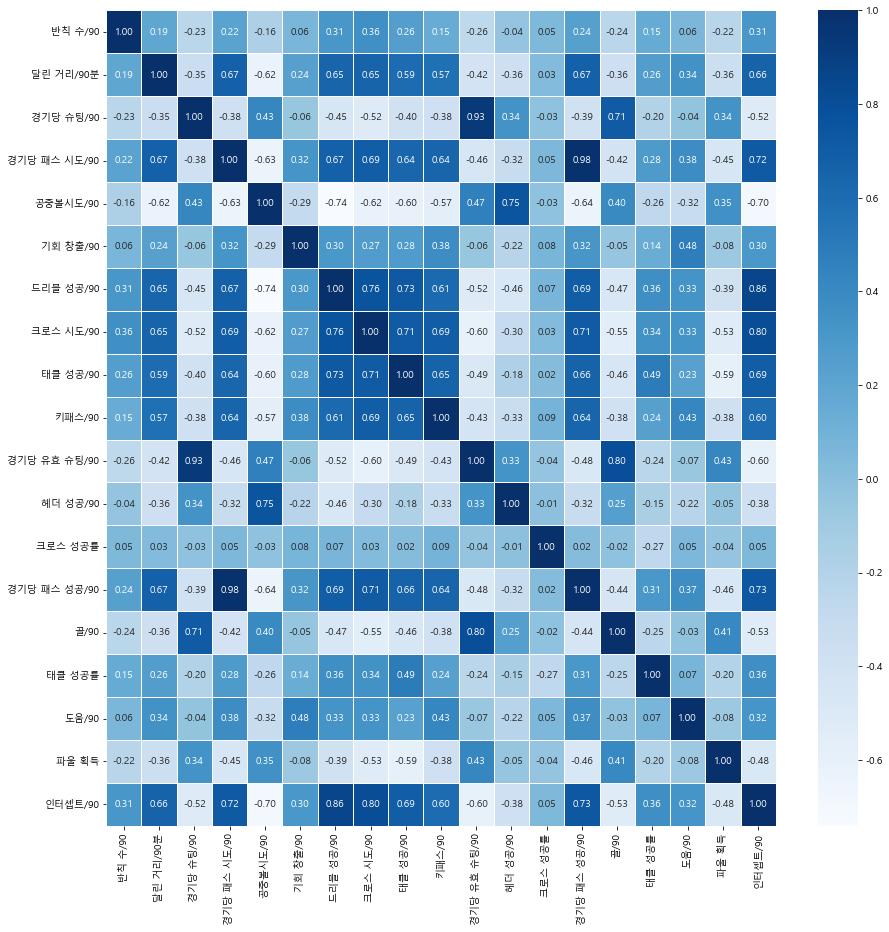

In [284]:
plt.figure(figsize=(15,15))
sns.heatmap(data = forward_df.loc[:,independent_value].corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues');

#### 독립변수 간 상관계수가 0.9이상인 변수들

In [285]:
# 상관계수의 절대값이 0.7 이상인것들
high_corr_list = []
feature_comb = list(combinations(independent_value,2))
corr_dict_pair = {}

# 골/90,도움/90 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
for a,b in feature_comb:
    spearmann = spearmanr(forward_df[[a,b]])
    corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    
    if spearmann[0] >= 0.9 or spearmann[0] <= -0.9:
        high_corr_list.append([a,b,spearmann[0]])

pd.DataFrame(high_corr_list,columns=['변수 1','변수 2','상관계수'])

,변수 1,변수 2,상관계수
0,경기당 슈팅/90,경기당 유효 슈팅/90,0.924238
1,경기당 패스 시도/90,경기당 패스 성공/90,0.975196


#### 종속변수와 독립변수간 상관계수

In [286]:
corr_dict_dependent = {}
corr_list_dependent = []

# 골/90,도움/90 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
for val in independent_value:
    spearmann = spearmanr(forward_df[[val,dependent_value]])
    corr_dict_dependent[f'{val} / {dependent_value}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    corr_list_dependent.append([val,dependent_value,spearmann[0]])

pd.DataFrame(sorted(corr_list_dependent,key=lambda x : np.abs(x[2]),reverse=True),columns=['종속변수','독립변수','상관계수']).head(20)

,종속변수,독립변수,상관계수
0,골/90,평균획득승점/경기,0.394212
1,도움/90,평균획득승점/경기,0.384576
2,경기당 유효 슈팅/90,평균획득승점/경기,0.306224
3,경기당 슈팅/90,평균획득승점/경기,0.289668
4,기회 창출/90,평균획득승점/경기,0.264929
5,드리블 성공/90,평균획득승점/경기,0.241909
6,공중볼시도/90,평균획득승점/경기,-0.221471
7,달린 거리/90분,평균획득승점/경기,0.200571
8,키패스/90,평균획득승점/경기,0.187770
9,경기당 패스 시도/90,평균획득승점/경기,0.184119


### 다중공선성 확인

In [287]:
this_vif = pd.DataFrame()
this_vif["VIF 계수"] = [vif(forward_df.loc[:,independent_value].values,i) for i in range(forward_df.loc[:,independent_value].values.shape[1])]
this_vif["종속변수"] = forward_df.loc[:,independent_value].columns
this_vif = this_vif.sort_values("VIF 계수").reset_index(drop=True)
this_vif

,VIF 계수,종속변수
0,4.043974,도움/90
1,5.494996,기회 창출/90
2,10.368317,크로스 시도/90
3,11.426933,크로스 성공률
4,11.635496,파울 획득
5,14.452758,반칙 수/90
6,18.809928,골/90
7,19.096232,태클 성공/90
8,23.805128,드리블 성공/90
9,28.438269,헤더 성공/90


## EDA Summary


- 모든 독립변수는 선형성을 만족한다.
- 이상치가 있는 row를 모두 삭제한다면 data loss가 너무 크므로 이상치에 강건한 스케일링을 활용해야 한다.
- 상관계수가 높은 독립변수간 상관관계제거, 다중공선성 해결 필요

# 데이터 전처리

## 전처리 중간중간 쓰일 함수

In [288]:
def check_vif(independent_value):
    this_vif = pd.DataFrame()
    this_vif["VIF 계수"] = [vif(forward_df.loc[:,independent_value].values,i) for i in range(forward_df.loc[:,independent_value].values.shape[1])]
    this_vif["종속변수"] = forward_df.loc[:,independent_value].columns
    this_vif = this_vif.sort_values("VIF 계수").reset_index(drop=True)
    return this_vif

In [289]:
def check_indepen_high_corr(independent_value):
    # 상관계수의 절대값이 0.7 이상인것들
    high_corr_list = []
    feature_comb = list(combinations(independent_value,2))
    corr_dict_pair = {}

    # 골/90,도움/90 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
    for a,b in feature_comb:
        spearmann = spearmanr(forward_df[[a,b]])
        corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    
        if spearmann[0] >= 0.9 or spearmann[0] <= -0.9:
            high_corr_list.append([a,b,spearmann[0]])

    return pd.DataFrame(high_corr_list,columns=['변수 1','변수 2','상관계수'])

In [290]:
def check_dependent_corr(independent_value):
    corr_dict_dependent = {}
    corr_list_dependent = []

    # 골/90,도움/90 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
    for val in independent_value:
        spearmann = spearmanr(forward_df[[val,dependent_value]])
        corr_dict_dependent[f'{val} / {dependent_value}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
        corr_list_dependent.append([val,dependent_value,spearmann[0]])

    df = pd.DataFrame(sorted(corr_list_dependent,key=lambda x : np.abs(x[2]),reverse=True),columns=['종속변수','독립변수','상관계수'])
    return df

## 결측치 처리

결측치가 없음

## 다중공선성, 상관계수 처리 (기준: VIF >= 10 , 상관계수 > =+- 0.7) 및 처리

1. 골/90,경기당 슈팅, 유효 슈팅
2. 도움/90, 패스시도,패스성공,키패스
3. 태클 성공률, 태클 성공/90
4. 공중볼 시도, 헤더성공
5. 드리블 시도
6. 인터셉트/90
7. 크로스시도 크로스 성공
8. 파울 획득
9. 반칙 수 /90
10. 달린거리/90분

### 골/90과 경기당 슈팅, 유효슈팅

#### 종속변수와 상관계수 확인(목표: 상관계수간 평균보다 높은 피쳐를 만들자)

In [291]:
forward_df[['골/90','경기당 유효 슈팅/90','경기당 슈팅/90','평균획득승점/경기']].corr()

,골/90,경기당 유효 슈팅/90,경기당 슈팅/90,평균획득승점/경기
골/90,1.000000,0.796165,0.709139,0.414000
경기당 유효 슈팅/90,0.796165,1.000000,0.925218,0.318149
경기당 슈팅/90,0.709139,0.925218,1.000000,0.299455
평균획득승점/경기,0.414000,0.318149,0.299455,1.000000


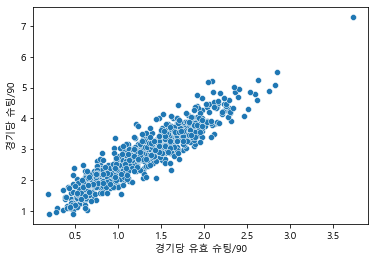

In [292]:
sns.scatterplot(x='경기당 유효 슈팅/90',y='경기당 슈팅/90',data=forward_df);

#### 피쳐 엔지니어링

In [293]:
# Goal_Shoot_linear
forward_df['GSL'] = (forward_df['경기당 유효 슈팅/90']+0.5) + (forward_df['경기당 슈팅/90']) + (forward_df['골/90']*1.3)

independent_value.add('GSL')
independent_value = independent_value - set(['골/90','경기당 슈팅/90','경기당 유효 슈팅/90'])

forward_df[['이름','GSL']].sort_values(by='GSL',ascending=False).head()

,이름,GSL
263,Erling Haaland,12.761198
2,Erling Haaland,9.906059
672,Erling Haaland,9.331343
529,Dušan Vlahović,9.145824
344,Ángel Correa,8.970805


#### 상관계수 확인 (통과)

In [294]:
forward_df[['GSL','평균획득승점/경기']].corr()

,GSL,평균획득승점/경기
GSL,1.000000,0.334434
평균획득승점/경기,0.334434,1.000000


In [295]:
check_vif(independent_value)

,VIF 계수,종속변수
0,4.024188,도움/90
1,5.448622,기회 창출/90
2,10.291210,크로스 시도/90
3,11.403384,크로스 성공률
4,11.441859,파울 획득
5,14.442807,반칙 수/90
6,19.007029,태클 성공/90
7,22.476873,GSL
8,23.749363,드리블 성공/90
9,28.383373,헤더 성공/90


In [296]:
check_indepen_high_corr(independent_value)

,변수 1,변수 2,상관계수
0,경기당 패스 시도/90,경기당 패스 성공/90,0.975196


### 경기당 패스 성공/90 경기당 패스 시도/90

#### 종속변수와 상관계수 확인(목표: 상관계수간 평균보다 높은 피쳐를 만들자)

In [297]:
forward_df[['경기당 패스 성공/90','경기당 패스 시도/90','평균획득승점/경기']].corr()

,경기당 패스 성공/90,경기당 패스 시도/90,평균획득승점/경기
경기당 패스 성공/90,1.000000,0.983568,0.216107
경기당 패스 시도/90,0.983568,1.000000,0.225951
평균획득승점/경기,0.216107,0.225951,1.000000


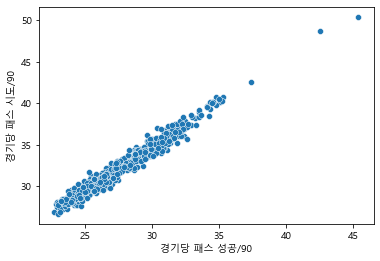

In [298]:
sns.scatterplot(x='경기당 패스 성공/90',y='경기당 패스 시도/90',data=forward_df);

#### 피쳐 엔지니어링

In [299]:
# PSTL = Pass sucess try linear

forward_df['PSTL'] = (forward_df['경기당 패스 성공/90']) + (forward_df['경기당 패스 시도/90'])

independent_value.add('PSTL')
independent_value = independent_value - set(['경기당 패스 성공/90','경기당 패스 시도/90'])

forward_df[['이름','PSTL']].sort_values(by='PSTL',ascending=False).head()

,이름,PSTL
433,Phil Foden,95.83
464,Kai Havertz,91.26
172,Phil Foden,80.02
205,Kai Havertz,76.11
454,Alex Iwobi,75.58


#### 상관계수 확인 (통과)

In [300]:
forward_df[['PSTL','평균획득승점/경기']].corr()

,PSTL,평균획득승점/경기
PSTL,1.000000,0.222106
평균획득승점/경기,0.222106,1.000000


### 크로스 시도/90 크로스 성공률

#### 종속변수와 상관계수 확인(목표: 상관계수간 평균보다 높은 피쳐를 만들자)

In [301]:
forward_df[['크로스 시도/90','크로스 성공률','평균획득승점/경기']].corr()

,크로스 시도/90,크로스 성공률,평균획득승점/경기
크로스 시도/90,1.000000,0.033467,0.054665
크로스 성공률,0.033467,1.000000,-0.025410
평균획득승점/경기,0.054665,-0.025410,1.000000


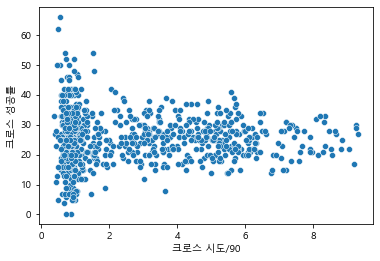

In [302]:
sns.scatterplot(x='크로스 시도/90',y='크로스 성공률',data=forward_df);

#### 피쳐 엔지니어링

In [303]:
# CACCL

forward_df['CACCL'] = (forward_df['크로스 시도/90']) + (forward_df['크로스 성공률'])

independent_value.add('CACCL')
independent_value = independent_value - set(['크로스 시도/90','크로스 성공률'])

forward_df[['이름','CACCL']].sort_values(by='CACCL',ascending=False).head()

,이름,CACCL
23,Brenner,66.54
760,Vincenzo Millico,62.49
744,Luis Muriel,55.52
260,Kevin Lasagna,54.69
223,Thomas Henry,52.98


#### 상관계수 확인 (통과)

In [304]:
forward_df[['CACCL','평균획득승점/경기']].corr()

,CACCL,평균획득승점/경기
CACCL,1.000000,-0.010328
평균획득승점/경기,-0.010328,1.000000


### 피쳐 삭제

In [305]:
independent_value

{'CACCL',
 'GSL',
 'PSTL',
 '공중볼시도/90',
 '기회 창출/90',
 '달린 거리/90분',
 '도움/90',
 '드리블 성공/90',
 '반칙 수/90',
 '인터셉트/90',
 '키패스/90',
 '태클 성공/90',
 '태클 성공률',
 '파울 획득',
 '헤더 성공/90'}

In [306]:
independent_value = independent_value - set(['달린 거리/90분','PSTL','공중볼시도/90','태클 성공률','인터셉트/90','키패스/90','반칙 수/90'])

In [307]:
check_dependent_corr(independent_value)

,종속변수,독립변수,상관계수
0,도움/90,평균획득승점/경기,0.384576
1,GSL,평균획득승점/경기,0.322374
2,기회 창출/90,평균획득승점/경기,0.264929
3,드리블 성공/90,평균획득승점/경기,0.241909
4,태클 성공/90,평균획득승점/경기,0.144568
5,헤더 성공/90,평균획득승점/경기,-0.103638
6,파울 획득,평균획득승점/경기,0.048281
7,CACCL,평균획득승점/경기,-0.000394


In [308]:
check_vif(independent_value)

,VIF 계수,종속변수
0,3.639309,도움/90
1,5.245827,기회 창출/90
2,7.432069,파울 획득
3,8.663433,헤더 성공/90
4,10.205352,CACCL
5,11.459834,태클 성공/90
6,11.760261,드리블 성공/90
7,15.450347,GSL


In [309]:
independent_value

{'CACCL',
 'GSL',
 '기회 창출/90',
 '도움/90',
 '드리블 성공/90',
 '태클 성공/90',
 '파울 획득',
 '헤더 성공/90'}

In [310]:
check_indepen_high_corr(independent_value)

,변수 1,변수 2,상관계수


### 최종 종속변수

In [311]:
independent_value

{'CACCL',
 'GSL',
 '기회 창출/90',
 '도움/90',
 '드리블 성공/90',
 '태클 성공/90',
 '파울 획득',
 '헤더 성공/90'}

In [312]:
forward_df.columns

Index(['이름', '포지션', '리그', '골/90', '도움/90', '경기당 팀 득점/90', '경기당 팀 실점/90',
       '크로스 성공률', '파울 획득', '반칙 수/90', '기회 창출/90', '경기당 유효 슈팅/90', '경기당 슈팅/90',
       '인터셉트/90', '달린 거리/90분', '공중볼시도/90', '태클 성공률', '경기당 패스 시도/90',
       '경기당 패스 성공/90', '키패스/90', '태클 성공/90', '드리블 성공/90', '헤더 성공/90',
       '크로스 시도/90', '평균획득승점/경기', '승', '무', '패', '시즌', '구단', 'GSL', 'PSTL',
       'CACCL'],
      dtype='object')

## 이상치 처리

이상치를 제외하면 데이터 손실이 너무 크기 때문에 Quantile transform을 사용해서 이상치를 고려한 normalization을 진행하기로 함.

## 데이터 정규화

In [313]:
x_train,x_test,y_train,y_test = train_test_split(forward_df.loc[:,independent_value],forward_df.loc[:,dependent_value])

forward_x_po = RobustScaler().fit(x_train.loc[:,independent_value])

x_train.loc[:,independent_value] = forward_x_po.transform(x_train.loc[:,independent_value])
x_test.loc[:,independent_value] = forward_x_po.transform(x_test.loc[:,independent_value])

# 모델 생성

In [314]:
inputs_layer = Input(shape=(len(independent_value),))
hidden1 = Dense(10,activation='relu')(inputs_layer)
hidden2 = Dense(256,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden1)
hidden3 = Dense(256,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden2)
hidden3 = Dense(20,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden2)
output = Dense(1,activation='linear')(hidden3)
model = Model(inputs=[inputs_layer],outputs=[output])
model.compile(loss='mse',optimizer=Adam(lr=0.001))
     
model.fit(x_train.loc[:,independent_value],y_train,batch_size=400,epochs=700,validation_data=(x_test.loc[:,independent_value],y_test))  
predict_result=model.predict(x_test.loc[:,independent_value])
mae = mean_absolute_error(y_test,predict_result)

Epoch 1/700
2/2 [==============================] - 0s 47ms/step - loss: 2.9178 - val_loss: 2.6877
Epoch 2/700
2/2 [==============================] - 0s 5ms/step - loss: 2.5755 - val_loss: 2.3472
Epoch 3/700
2/2 [==============================] - 0s 5ms/step - loss: 2.2474 - val_loss: 2.0266
Epoch 4/700
2/2 [==============================] - 0s 5ms/step - loss: 1.9408 - val_loss: 1.7296
Epoch 5/700
2/2 [==============================] - 0s 5ms/step - loss: 1.6545 - val_loss: 1.4619
Epoch 6/700
2/2 [==============================] - 0s 5ms/step - loss: 1.3985 - val_loss: 1.2301
Epoch 7/700
2/2 [==============================] - 0s 5ms/step - loss: 1.1838 - val_loss: 1.0510
Epoch 8/700
2/2 [==============================] - 0s 5ms/step - loss: 1.0183 - val_loss: 0.9360
Epoch 9/700
2/2 [==============================] - 0s 6ms/step - loss: 0.9186 - val_loss: 0.8863
Epoch 10/700
2/2 [==============================] - 0s 6ms/step - loss: 0.8853 - val_loss: 0.8878
Epoch 11/700
2/2 [==========

2/2 [==============================] - 0s 6ms/step - loss: 0.3154 - val_loss: 0.3340
Epoch 85/700
2/2 [==============================] - 0s 6ms/step - loss: 0.3132 - val_loss: 0.3317
Epoch 86/700
2/2 [==============================] - 0s 5ms/step - loss: 0.3110 - val_loss: 0.3296
Epoch 87/700
2/2 [==============================] - 0s 5ms/step - loss: 0.3086 - val_loss: 0.3276
Epoch 88/700
2/2 [==============================] - 0s 6ms/step - loss: 0.3064 - val_loss: 0.3255
Epoch 89/700
2/2 [==============================] - 0s 5ms/step - loss: 0.3042 - val_loss: 0.3237
Epoch 90/700
2/2 [==============================] - 0s 6ms/step - loss: 0.3023 - val_loss: 0.3219
Epoch 91/700
2/2 [==============================] - 0s 6ms/step - loss: 0.3003 - val_loss: 0.3199
Epoch 92/700
2/2 [==============================] - 0s 5ms/step - loss: 0.2982 - val_loss: 0.3178
Epoch 93/700
2/2 [==============================] - 0s 5ms/step - loss: 0.2962 - val_loss: 0.3158
Epoch 94/700
2/2 [===============

2/2 [==============================] - 0s 5ms/step - loss: 0.2031 - val_loss: 0.2278
Epoch 168/700
2/2 [==============================] - 0s 5ms/step - loss: 0.2024 - val_loss: 0.2271
Epoch 169/700
2/2 [==============================] - 0s 6ms/step - loss: 0.2015 - val_loss: 0.2261
Epoch 170/700
2/2 [==============================] - 0s 5ms/step - loss: 0.2008 - val_loss: 0.2251
Epoch 171/700
2/2 [==============================] - 0s 5ms/step - loss: 0.2000 - val_loss: 0.2244
Epoch 172/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1994 - val_loss: 0.2238
Epoch 173/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1986 - val_loss: 0.2234
Epoch 174/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1982 - val_loss: 0.2234
Epoch 175/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1973 - val_loss: 0.2225
Epoch 176/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1963 - val_loss: 0.2217
Epoch 177/700
2/2 [=====

Epoch 250/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1593 - val_loss: 0.1872
Epoch 251/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1589 - val_loss: 0.1862
Epoch 252/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1584 - val_loss: 0.1858
Epoch 253/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1582 - val_loss: 0.1856
Epoch 254/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1578 - val_loss: 0.1856
Epoch 255/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1573 - val_loss: 0.1857
Epoch 256/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1571 - val_loss: 0.1858
Epoch 257/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1570 - val_loss: 0.1852
Epoch 258/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1569 - val_loss: 0.1844
Epoch 259/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1560 - val_loss: 0.1842
Epoch 260/

2/2 [==============================] - 0s 5ms/step - loss: 0.1397 - val_loss: 0.1675
Epoch 333/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1398 - val_loss: 0.1673
Epoch 334/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1392 - val_loss: 0.1671
Epoch 335/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1392 - val_loss: 0.1669
Epoch 336/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1389 - val_loss: 0.1662
Epoch 337/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1387 - val_loss: 0.1660
Epoch 338/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1386 - val_loss: 0.1659
Epoch 339/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1383 - val_loss: 0.1665
Epoch 340/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1384 - val_loss: 0.1664
Epoch 341/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1381 - val_loss: 0.1660
Epoch 342/700
2/2 [=====

Epoch 415/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1300 - val_loss: 0.1569
Epoch 416/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1303 - val_loss: 0.1566
Epoch 417/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1301 - val_loss: 0.1567
Epoch 418/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1296 - val_loss: 0.1570
Epoch 419/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1296 - val_loss: 0.1570
Epoch 420/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1295 - val_loss: 0.1569
Epoch 421/700
2/2 [==============================] - ETA: 0s - loss: 0.131 - 0s 5ms/step - loss: 0.1296 - val_loss: 0.1569
Epoch 422/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1292 - val_loss: 0.1576
Epoch 423/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1294 - val_loss: 0.1578
Epoch 424/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1294 - val

2/2 [==============================] - 0s 5ms/step - loss: 0.1246 - val_loss: 0.1522
Epoch 498/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1244 - val_loss: 0.1521
Epoch 499/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1244 - val_loss: 0.1520
Epoch 500/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1243 - val_loss: 0.1521
Epoch 501/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1243 - val_loss: 0.1526
Epoch 502/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1243 - val_loss: 0.1528
Epoch 503/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1242 - val_loss: 0.1528
Epoch 504/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1241 - val_loss: 0.1523
Epoch 505/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1240 - val_loss: 0.1520
Epoch 506/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1241 - val_loss: 0.1520
Epoch 507/700
2/2 [=====

Epoch 580/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1212 - val_loss: 0.1494
Epoch 581/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1210 - val_loss: 0.1499
Epoch 582/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1212 - val_loss: 0.1502
Epoch 583/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1212 - val_loss: 0.1500
Epoch 584/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1210 - val_loss: 0.1496
Epoch 585/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1210 - val_loss: 0.1495
Epoch 586/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1211 - val_loss: 0.1495
Epoch 587/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1214 - val_loss: 0.1494
Epoch 588/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1212 - val_loss: 0.1494
Epoch 589/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1212 - val_loss: 0.1499
Epoch 590/

2/2 [==============================] - 0s 5ms/step - loss: 0.1194 - val_loss: 0.1490
Epoch 663/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1196 - val_loss: 0.1478
Epoch 664/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1192 - val_loss: 0.1473
Epoch 665/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1191 - val_loss: 0.1474
Epoch 666/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1191 - val_loss: 0.1474
Epoch 667/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1198 - val_loss: 0.1473
Epoch 668/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1195 - val_loss: 0.1487
Epoch 669/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1193 - val_loss: 0.1474
Epoch 670/700
2/2 [==============================] - 0s 6ms/step - loss: 0.1190 - val_loss: 0.1476
Epoch 671/700
2/2 [==============================] - 0s 5ms/step - loss: 0.1201 - val_loss: 0.1474
Epoch 672/700
2/2 [=====

In [315]:
mae

0.29856249208895036

In [316]:
independent_value

{'CACCL',
 'GSL',
 '기회 창출/90',
 '도움/90',
 '드리블 성공/90',
 '태클 성공/90',
 '파울 획득',
 '헤더 성공/90'}

In [317]:
forward_df.loc[:,independent_value] = forward_x_po.transform(forward_df.loc[:,independent_value])

In [318]:
y_pred = model.predict(forward_df.loc[:,independent_value])

In [319]:
forward_df['예측_PPG'] = y_pred

In [320]:
forward_df.sort_values(by='예측_PPG',ascending=False).head(10)

,이름,포지션,리그,골/90,도움/90,경기당 팀 득점/90,경기당 팀 실점/90,크로스 성공률,파울 획득,반칙 수/90,...,평균획득승점/경기,승,무,패,시즌,구단,GSL,PSTL,CACCL,예측_PPG
155,Neymar,공격수,프랑스 리그 1,0.540338,1.821946,2.26,0.71,34.0,-0.105960,1.42,...,2.39,32.0,2.0,7.0,2021-2022,파리-SG,0.947773,63.05,0.838934,2.411940
710,Giacomo Raspadori,공격수,잉글랜드 프리미어 리그,0.702128,0.835848,2.43,0.57,32.0,-0.900662,1.15,...,2.53,28.0,2.0,4.0,2023-2024,첼시,1.493705,66.19,0.609965,2.380540
263,Erling Haaland,공격수,독일 분데스리가,0.947075,1.355045,2.20,0.92,14.0,2.066225,0.70,...,2.02,25.0,10.0,7.0,2022-2023,도르트문트,3.472038,57.21,-1.243105,2.375363
711,Gabriel Jesus,공격수,잉글랜드 프리미어 리그,0.457849,3.745162,2.16,1.05,29.0,-0.370861,1.18,...,2.47,37.0,5.0,5.0,2023-2024,첼시,0.141414,66.74,0.753650,2.296295
567,Yeremy Pino,공격수,스페인 프리메라 디비전,0.485961,1.926604,2.19,0.53,29.0,0.026490,1.07,...,2.32,38.0,9.0,6.0,2023-2024,레알 마드리드,0.769976,69.76,0.386559,2.226892
274,Leroy Sané,공격수,독일 분데스리가,0.422252,2.065987,2.71,0.63,24.0,-0.052980,1.06,...,2.56,39.0,6.0,3.0,2022-2023,FC 바이에른,0.138629,67.11,0.106605,2.205478
531,Leroy Sané,공격수,독일 분데스리가,0.400445,1.351376,2.15,1.00,39.0,-0.397351,0.85,...,2.30,22.0,3.0,5.0,2023-2024,FC 바이에른,0.281355,65.42,1.529548,2.179453
172,Phil Foden,공격수,잉글랜드 프리미어 리그,0.420315,1.460280,1.94,0.89,37.0,-0.874172,0.84,...,2.50,21.0,2.0,3.0,2021-2022,맨시티,0.066515,80.02,1.243105,2.178471
271,Amine Gouiri,공격수,독일 분데스리가,0.341053,1.815088,1.74,1.25,25.0,-0.132450,1.44,...,1.62,16.0,7.0,11.0,2022-2023,묀헨글라드바흐,0.668637,64.95,0.009270,2.154437
673,Mohamed Salah,공격수,잉글랜드 프리미어 리그,0.451128,1.958823,1.88,0.68,27.0,0.635762,1.09,...,2.25,37.0,13.0,5.0,2023-2024,리버풀,0.559079,67.03,0.474623,2.151663


# 모델검정

In [321]:
residual = forward_df['평균획득승점/경기'] - forward_df['예측_PPG']

## 잔차의 정규성 검정

In [322]:
# 정규성 만족
stats.shapiro(residual)

ShapiroResult(statistic=0.9978981614112854, pvalue=0.4558311998844147)

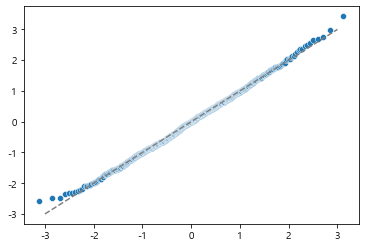

In [323]:
sr = stats.zscore(residual)
(x, y), _ = stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey');

## 잔차의 등분산성 검정

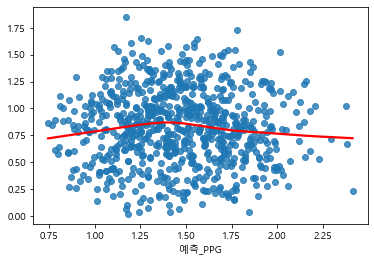

In [324]:
sns.regplot(forward_df['예측_PPG'], np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'});

In [325]:
# 등분산성 불만족
stats.levene(forward_df['평균획득승점/경기'],forward_df['예측_PPG'])

LeveneResult(statistic=117.42515810833234, pvalue=2.023758501723025e-26)

In [326]:
from statsmodels.stats.stattools import durbin_watson

# 독립성 불만족
durbin_watson(residual)

1.2053263019473481

In [327]:
mean_absolute_error(forward_df['평균획득승점/경기'],forward_df['예측_PPG'])

0.2729427678854085

In [328]:
np.sqrt(mean_squared_error(forward_df['평균획득승점/경기'],forward_df['예측_PPG']))

0.33959883390300105

In [329]:
with open('./models/forward/forward_qt.pickle','wb') as f:
     pickle.dump(forward_x_po,f)

In [330]:
model.save('./models/forward/forward_nn_high.h5')